In [1]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import inv,pinv
from scipy.optimize import minimize

In [3]:
# risk budgeting optimization
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]# covariance table
    x_t = pars[1] # risk target in percent of portfolio risk
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x

# Прогружаем данные

In [4]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green');

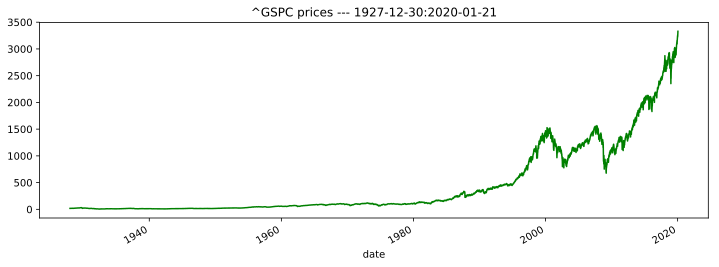

In [15]:
download_csv_data(ticker='^GSPC', 
                  start_date='1927-12-30', 
                  end_date='2020-01-21', 
                  freq='daily', 
                  path='data/S&P.csv')

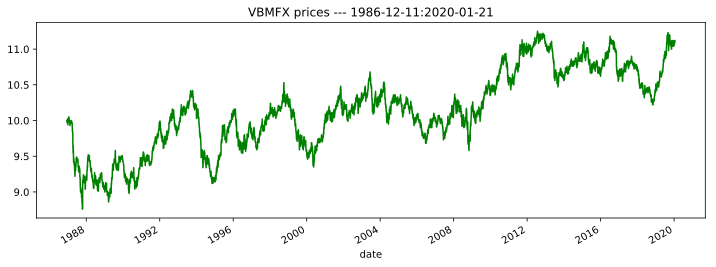

In [16]:
download_csv_data(ticker='VBMFX', 
                  start_date='1986-12-11', 
                  end_date='2020-01-21', 
                  freq='daily', 
                  path='data/USBonds.csv')

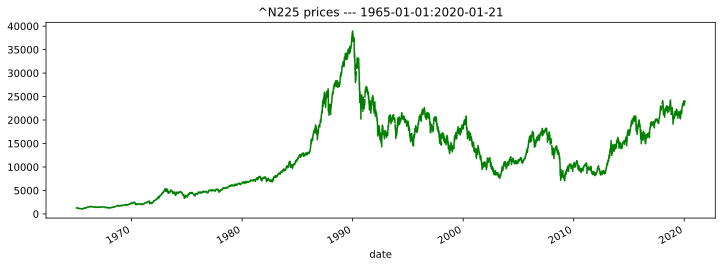

In [7]:
download_csv_data(ticker='^N225', 
                  start_date='1965-01-01', 
                  end_date='2020-01-21', 
                  freq='daily', 
                  path='data/N225.csv')

In [17]:
# Список финансовых инструментов в портфеле
TIKERS = ['S&P', 'USBonds']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [18]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                   open        close
date                                
2020-01-13  3288.129883  3288.129883
2020-01-14  3283.149902  3283.149902
2020-01-15  3289.290039  3289.290039
2020-01-16  3316.810059  3316.810059
2020-01-17  3329.620117  3329.620117
             open  close
date                    
2020-01-13  11.09  11.09
2020-01-14  11.11  11.11
2020-01-15  11.12  11.12
2020-01-16  11.11  11.11
2020-01-17  11.10  11.10


In [19]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 33622 (major_axis) x 2 (minor_axis)
Items axis: S&P to USBonds
Major_axis axis: 1927-12-30 00:00:00+00:00 to 2020-01-17 00:00:00+00:00
Minor_axis axis: open to close


# Взаимная корреляция

In [20]:
data_corr = data['S&P']
for tiker in TIKERS:
    data_corr[tiker] = data[tiker]['close']
del data_corr['open']
del data_corr['close']
data_corr.corr()

,S&P,USBonds
S&P,1.000000,0.894684
USBonds,0.894684,1.000000


# Risk

### Определяем стартовые переменные

In [21]:
num_assets = len(TIKERS)
performance_list = []
COMMISSION = 0


# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

In [22]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))

    #set_benchmark(symbol('BTC'))

    context.tikers = ['S&P']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(1927, 12, 30, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 1, 17, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

SP500 = perf.algorithm_period_return

SP500 = 1000 * (1 + SP500)

SP500 = SP500.rename('S&P 500')

In [23]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))

    #set_benchmark(symbol('BTC'))

    context.tikers = ['USBonds']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(1986, 12, 11, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 1, 17, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

USBonds = perf.algorithm_period_return

USBonds = 1000 * (1 + USBonds)

USBonds = USBonds.rename('US Bonds')

# Визуализация результатов

In [178]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(TIKERS):
    portfolio[symbol] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock for stock in TIKERS]

# reorder dataframe columns
df = df[column_order]

In [179]:
df.head()

,Returns,Volatility,Sharpe Ratio,S&P,USBonds
0,7.688106,17.395436,0.512909,1,0
1,5.749990,4.136866,1.372267,1,0


In [180]:
df = df.append(df, ignore_index=True)

In [181]:
df = df.append(df, ignore_index=True)

In [182]:
df = df.append(df, ignore_index=True)

In [183]:
df = df.rename(columns={"Sharpe Ratio": "Name"})

In [184]:
df = df.drop(range(11, 16))

# Cash

In [185]:
df['Name'][0] = 'Cash'
df['Volatility'][0] = 0
df['Returns'][0] = 3.5

# Inflation Linked Bonds

In [201]:
df['Name'][1] = 'Inflation\nLinked\nBonds'
df['Volatility'][1] = 5
df['Returns'][1] = 4.7

# Non-US Fixed Income (hedged)

In [205]:
df['Name'][2] = 'Non-US\nFixed Income\n(hedged)'
df['Volatility'][2] = 5.5
df['Returns'][2] = 4.9

# Core US Fixed Income

In [206]:
df['Name'][3] = 'Core\nUS Fixed\nIncome'
df['Volatility'][3] = 6
df['Returns'][3] = 5.1

# Real Estate

In [189]:
df['Name'][4] = 'Real Estate'
df['Volatility'][4] = 10
df['Returns'][4] = 7.2

# High Yield Debt

In [207]:
df['Name'][5] = 'High Yield\nDebt'
df['Volatility'][5] = 10.5
df['Returns'][5] = 7.3

# US Equities

In [191]:
df['Name'][6] = 'US Equities'
df['Volatility'][6] = 17
df['Returns'][6] = 8.7

# Emerging Market Debt

In [208]:
df['Name'][7] = 'Emerging\nMarket Debt'
df['Volatility'][7] = 17
df['Returns'][7] = 8.6

# Non-US Equities

In [193]:
df['Name'][8] = 'Non-US Equities'
df['Volatility'][8] = 19
df['Returns'][8] = 9.2

# Emerging Equities

In [209]:
df['Name'][9] = 'Emerging\nEquities'
df['Volatility'][9] = 30
df['Returns'][9] = 14.6

# Private Equity

In [210]:
df['Name'][10] = 'Private\nEquity'
df['Volatility'][10] = 35
df['Returns'][10] = 16

In [211]:
df

,Returns,Volatility,Name,S&P,USBonds
0,3.5,0.0,Cash,1,0
1,4.7,5.0,Inflation\nLinked\nBonds,1,0
2,4.9,5.5,Non-US\nFixed Income\n(hedged),1,0
3,5.1,6.0,Core\nUS Fixed\nIncome,1,0
4,7.2,10.0,Real Estate,1,0
5,7.3,10.5,High Yield\nDebt,1,0
6,8.7,17.0,US Equities,1,0
7,8.6,17.0,Emerging\nMarket Debt,1,0
8,9.2,19.0,Non-US Equities,1,0
9,14.6,30.0,Emerging\nEquities,1,0


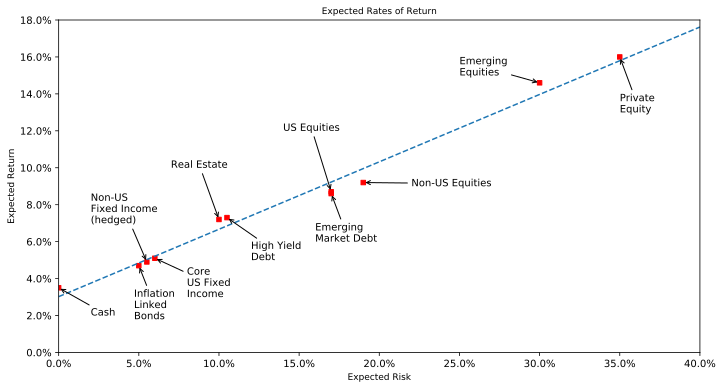

In [236]:
#fig, ax = plt.subplots()
# plot frontier, max sharpe & min Volatility values with a scatterplot
ax = df.plot.scatter(x='Volatility', y='Returns', marker = 's', color='r', edgecolors='r', figsize=(11.5, 6))
plt.xlabel('Expected Risk', fontsize = 9)
plt.ylabel('Expected Return', fontsize = 9)
plt.title('Expected Rates of Return', fontsize = 9)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set(xlim=(0, 40), ylim=(0, 18))

#https://matplotlib.org/3.1.1/tutorials/text/annotations.html

plt.annotate(df.iloc[0]['Name'], xy=(df.iloc[0]['Volatility'], df.iloc[0]['Returns']), xytext=(2, 2),
             arrowprops=dict(arrowstyle="->"))

plt.annotate(df.iloc[1]['Name'], xy=(df.iloc[1]['Volatility'], df.iloc[1]['Returns']), xytext=(4.7, 1.8),
             arrowprops=dict(arrowstyle="->"))

plt.annotate(df.iloc[2]['Name'], xy=(df.iloc[2]['Volatility'], df.iloc[2]['Returns']), xytext=(2, 7),
             arrowprops=dict(arrowstyle="->"))

plt.annotate(df.iloc[3]['Name'], xy=(df.iloc[3]['Volatility'], df.iloc[3]['Returns']), xytext=(8, 3),
             arrowprops=dict(arrowstyle="->"))

plt.annotate(df.iloc[4]['Name'], xy=(df.iloc[4]['Volatility'], df.iloc[4]['Returns']), xytext=(7, 10),
             arrowprops=dict(arrowstyle="->"))

plt.annotate(df.iloc[5]['Name'], xy=(df.iloc[5]['Volatility'], df.iloc[5]['Returns']), xytext=(12, 5),
             arrowprops=dict(arrowstyle="->"))

plt.annotate(df.iloc[6]['Name'], xy=(df.iloc[6]['Volatility'], df.iloc[6]['Returns']), xytext=(14, 12),
             arrowprops=dict(arrowstyle="->"))

plt.annotate(df.iloc[7]['Name'], xy=(df.iloc[7]['Volatility'], df.iloc[7]['Returns']), xytext=(16, 6),
             arrowprops=dict(arrowstyle="->"))

plt.annotate(df.iloc[8]['Name'], xy=(df.iloc[8]['Volatility'], df.iloc[8]['Returns']), xytext=(22, 9),
             arrowprops=dict(arrowstyle="->"))

plt.annotate(df.iloc[9]['Name'], xy=(df.iloc[9]['Volatility'], df.iloc[9]['Returns']), xytext=(25, 15),
             arrowprops=dict(arrowstyle="->"))

plt.annotate(df.iloc[10]['Name'], xy=(df.iloc[10]['Volatility'], df.iloc[10]['Returns']), xytext=(35, 13),
             arrowprops=dict(arrowstyle="->"))

x = np.linspace(0, 40, 1000)
plt.plot(x, 3.020191 + 0.365019*x, linestyle='--')
#3.020191
plt.show()

fig.savefig('Assets.png', transparent=False, dpi=500, bbox_inches="tight")